
# **NOME**: MARIA MARCOLINA LIMA CARDOSO

## **MATRÍCULA**: 2023002133

### **Descrição**
Este exercício tem por objetivo treinar uma rede neural 
deste exercício é treinar e avaliar uma rede neural recorrente (RNN
ou LSTM) para classificar um conjunto de dados sobre notícias de acordo com
suas categorias.
A rede neural pode ser criada utilizando o PyTorch ou Tensorflow/Keras. A rede
neural deve ser avaliada através do cálculo da acurácia (quantidade de acertos
dividido pela quantidade total de testes).
### **Dados**
Os dados utilizados são dados de notícias e suas categorias disponíveis através
da biblioteca datasets. Os dados podem ser acessados assim:
import datasets
dataset = datasets.load_dataset("okite97/news-data")
Esse conjunto de dados contém 3 campos: o título da notícia, um trecho da
notícia e a categoria. Você deve usar o título ou o trecho para encontrar a
categoria.

**Importando as bibliotecascnecessárias**

In [517]:
import datasets
import pandas as pd


from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
import nltk
import string

from collections import Counter

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mariaeco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [518]:
dataset = datasets.load_dataset("okite97/news-data")
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 828
    })
})

In [519]:
#conjunto treino
dataset['train']['Title'][:10]

['Uefa Opens Proceedings against Barcelona, Juventus and Real Madrid Over European Super League Plan',
 'Amazon\xa0Blames Inflation as It Increases Cost of\xa0Prime\xa0in\xa0Europe',
 'Nigeria’s Parliament Passes Amended Electoral Bill',
 'Nigeria: Lagos Governor Tests Positive for Covid-19, Kaduna Governor Self-Isolates',
 'South Africa Calls For Calm as Electoral Reform Protests Continue in Eswatini',
 'Guardiola To Leave Man City When Contract Expires in 2023',
 'Nigeria: Sultan of Sokoto Seeks Removal of Immunity Clause for Politicians',
 'Again, Nigeria Senate\xa0Demands\xa0Rejig of Nigeria’s Security Architecture',
 'Nigeria: South-East’s Most Important  Demand is Reintegration, Agitations Will End with Igbo Presidency, Says Ex-Senate President Anyim',
 'Premier League Clubs Reject ‘Project Big Picture’']

In [520]:
dataset['test']['Title'][:10]

['Nigeria: Cross River Governor Ayade Dumps PDP for APC',
 'Electoral Bill: Nigeria Senate Mobilises to Override President’s Veto, House Defers Battle Till January',
 'Nigeria: Central Bank Increases Forex Allocation to Banks',
 'Nigeria to Set Up Fund to Cover 83m Poor Citizens, as Buhari Signs National Health Authority Bill into Law',
 'World Bank Revises Sub-Saharan Africa’s Growth Forecast to 3.4%',
 'Putin Signs Law Paving Way to Rule Until 2036',
 'Lagos Suspends  NURTW From Parks, Takes Over Transport Union’s Operations',
 'Power Devolution, State Police Demands Dominate Nigeria’s Constitution Review Hearings',
 'Former Champions Ghana, South Africa Set For AFCON Qualifiers Showdown in Johannesburg Thursday',
 'New Petroleum Act: Nigeria Says No Immediate Removal of Petrol Subsidy']

In [521]:
print("Categorias treino", np.unique(dataset['train']['Category']), "\nCategorias teste",np.unique(dataset['test']['Category']))

Categorias treino ['business' 'entertainment' 'health' 'politics' 'sports' 'tech'] 
Categorias teste ['business' 'entertainment' 'health' 'politics' 'sports' 'tech']


### Transformando texto em numero

In [522]:
def create_labels(row):
    label = row['Category']
    if label == 'sports':
        row['label'] = 0
    if label == 'business':
        row['label'] = 1
    if label == 'health':
        row['label'] = 2
    if label == 'tech':
        row['label'] = 3
    if label == 'entertainment':
        row['label'] = 4
    if label == 'politics':
        row['label'] = 5
    return row

dataset = dataset.map(create_labels)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'label'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'label'],
        num_rows: 828
    })
})


In [523]:
def split_tokens(row):
    tokens = word_tokenize(row['Excerpt'].lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    row['tokens'] = tokens
    return row

dataset = dataset.map(split_tokens)


In [524]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'label', 'tokens'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'label', 'tokens'],
        num_rows: 828
    })
})

In [525]:
all_tokens = []

for tokens in dataset['train']['tokens']:
  all_tokens.extend(tokens)

len(all_tokens)

57058

In [526]:
counts = Counter(all_tokens)
counts.most_common(20)

[('nigeria', 941),
 ('president', 510),
 ('said', 394),
 ('nigerian', 346),
 ('state', 291),
 ('national', 287),
 ('government', 267),
 ('new', 256),
 ('world', 240),
 ('first', 238),
 ('tuesday', 216),
 ('thursday', 215),
 ('united', 213),
 ('federal', 212),
 ('us', 212),
 ('league', 211),
 ('country', 211),
 ('governor', 209),
 ('former', 208),
 ('bank', 207)]

In [527]:
vocab = [token for token, count in counts.items() if count >= 2]
vocab = ['<unk>'] + vocab #precisamos inserir para tokens desconhecidos
len(vocab)

5343

In [528]:
token2id = {token: idx for idx, token in enumerate(vocab)} #mapeando os ids para os tokens

In [529]:
def convert_tokens(tokens):
  result = []
  for token in tokens:
    result.append(token2id.get(token, 0))

  return result
    
# res = convert_tokens(df_train['tokens'][200]) #indices dos tokens da linha
def tokens2id(row):
    row['tokens_id'] = convert_tokens(row['tokens'])
    return row
dataset = dataset.map(tokens2id)

In [530]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'label', 'tokens', 'tokens_id'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'label', 'tokens', 'tokens_id'],
        num_rows: 828
    })
})

### Primeiro precisamos converter o dado em tensores pythorch

In [531]:
class Datatorch(Dataset):
  def __init__(self, dataset):
    self.data = dataset['tokens_id']
    self.labels = dataset['label']

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

In [532]:
train_data = Datatorch(dataset['train'])
train_data[1000]

(tensor([   0, 1449, 2061,  978, 1020, 3461,  244,    0, 3007]), tensor(0))

In [533]:
from torch import nn

EMBED_LEN = 128
HIDDEN_DIM = 32
N_LAYERS = 2

class TextClassifier(nn.Module):
  def __init__(self):
    super(TextClassifier, self).__init__()

    self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),embedding_dim=EMBED_LEN)
    self.rnn = nn.RNN(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS)
    self.linear = nn.Linear(HIDDEN_DIM,6) # 6 CLASSES
    self.CrossEntropyLoss = nn.CrossEntropyLoss()

  def forward(self, input, target=None):
    embeddings = self.embedding_layer(input)
    # print('embeddings', embeddings)
    # print('embeddings shape', embeddings.shape)
    output, final_hidden = self.rnn(embeddings)
    return self.linear(final_hidden[-1])

In [534]:
model = TextClassifier()
model(torch.tensor(dataset['train']['tokens_id'][0]), torch.tensor(dataset['train']['label'][0]))
out = model(torch.tensor(dataset['train']['tokens_id'][0]), torch.tensor(dataset['train']['label'][0]))

In [535]:
LR = 1e-3
EPOCHS = 5
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [536]:
from tqdm.notebook import tqdm

def train(dataloader):
  size = len(dataloader.dataset)
  train_loss = 0

  for batch, (data, label) in enumerate(tqdm(dataloader)):
      data, label = data.to(device), label.to(device) 
      out = model(data[0],label) 
      loss = model.CrossEntropyLoss(out.squeeze(0), label.squeeze().to(torch.long)) 
      train_loss += loss.item()

      
      optimizer.zero_grad()# Backpropagation através do tempo e atualização dos pesos
      loss.backward()
      optimizer.step()

      if batch % 1000 == 0:
          loss, current = loss.item(), batch * len(data)
          print(f' loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

  train_loss /= size 

  return train_loss

In [537]:
def test(dataloader):
  size = len(dataloader.dataset)
  test_loss = 0
  correct = 0

  with torch.no_grad(): 
    for data, label in tqdm(dataloader):
      data, label = data.to(device), label.to(device)
      out = model(data[0],label)

      loss = model.CrossEntropyLoss(out.squeeze(0), label.squeeze().to(torch.long))
      test_loss += loss.item()

      label_out = torch.argmax(out).to(torch.long)

      if label_out == label[0]:
        correct += 1


  test_loss /= size  
  correct /= size  

  print(f' test accuracy: {(100*correct):>0.1f}%, test loss: {test_loss:>8f} ')

  return test_loss

In [538]:
device = torch.device('cpu')
model.to(device)

TextClassifier(
  (embedding_layer): Embedding(5343, 128)
  (rnn): RNN(128, 32, num_layers=2)
  (linear): Linear(in_features=32, out_features=6, bias=True)
  (CrossEntropyLoss): CrossEntropyLoss()
)

In [539]:
dataloader_train = DataLoader(train_data, shuffle=True)
dataloader_test = DataLoader(Datatorch(dataset['test']), shuffle=True)


In [540]:
train_losses = []
test_losses = []

for t in range(EPOCHS):
    print(f'Epoch {t+1} -------------------------------')

    print('Train')
    train_losses.append(train(dataloader_train))

    print('Test')
    test_losses.append(test(dataloader_test))

Epoch 1 -------------------------------
Train


  0%|          | 0/4686 [00:00<?, ?it/s]

 loss: 1.748202  [    0/ 4686]
 loss: 1.412012  [ 1000/ 4686]
 loss: 1.413398  [ 2000/ 4686]
 loss: 0.484908  [ 3000/ 4686]
 loss: 2.970386  [ 4000/ 4686]
Test


  0%|          | 0/828 [00:00<?, ?it/s]

 test accuracy: 60.5%, test loss: 1.139613 
Epoch 2 -------------------------------
Train


  0%|          | 0/4686 [00:00<?, ?it/s]

 loss: 0.533843  [    0/ 4686]
 loss: 3.060562  [ 1000/ 4686]
 loss: 0.113222  [ 2000/ 4686]
 loss: 3.068547  [ 3000/ 4686]
 loss: 2.868310  [ 4000/ 4686]
Test


  0%|          | 0/828 [00:00<?, ?it/s]

 test accuracy: 66.8%, test loss: 0.979753 
Epoch 3 -------------------------------
Train


  0%|          | 0/4686 [00:00<?, ?it/s]

 loss: 1.349812  [    0/ 4686]
 loss: 0.238379  [ 1000/ 4686]
 loss: 2.556754  [ 2000/ 4686]
 loss: 0.041898  [ 3000/ 4686]
 loss: 0.090452  [ 4000/ 4686]
Test


  0%|          | 0/828 [00:00<?, ?it/s]

 test accuracy: 71.7%, test loss: 0.884819 
Epoch 4 -------------------------------
Train


  0%|          | 0/4686 [00:00<?, ?it/s]

 loss: 0.700789  [    0/ 4686]
 loss: 0.532810  [ 1000/ 4686]
 loss: 0.023183  [ 2000/ 4686]
 loss: 1.340556  [ 3000/ 4686]
 loss: 0.019631  [ 4000/ 4686]
Test


  0%|          | 0/828 [00:00<?, ?it/s]

 test accuracy: 70.5%, test loss: 0.910283 
Epoch 5 -------------------------------
Train


  0%|          | 0/4686 [00:00<?, ?it/s]

 loss: 0.140695  [    0/ 4686]
 loss: 1.546795  [ 1000/ 4686]
 loss: 0.031067  [ 2000/ 4686]
 loss: 0.049410  [ 3000/ 4686]
 loss: 0.027888  [ 4000/ 4686]
Test


  0%|          | 0/828 [00:00<?, ?it/s]

 test accuracy: 69.6%, test loss: 0.904897 


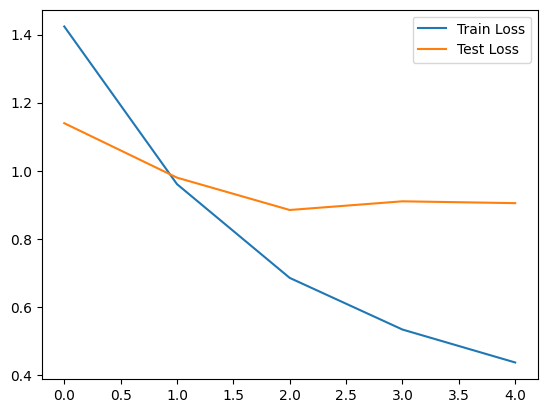

In [541]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()